**목표**  
- **서울:** `bicycle_accidents_2023.xlsx`에서 자치구별 자전거 **사고건수(건)** 산출  
- **경기:** `bicycle_accidents_hotspot_status.xlsx`에서 시군별 **총사고건수(핫스팟 발생건수)** 산출  
- 두 지역의 **주변 자전거도로 길이(km)** 와 **자전거 사고 건수(건/km)** 간의 관계를  
  **회귀분석(OLS)** 및 **시각화**로 비교  

> ⚠️ 행정단위가 다름 — *서울=자치구*, *경기=시·군*  
> 본 분석은 **자전거도로 인프라의 밀도(연장)** 가 **사고 빈도에 미치는 영향**을  
> **범주형 더미 회귀 분석** 관점에서 비교합니다.

---

### 📈 분석 주요 내용
1. **자전거 사고 건수(건/km)** — 지역별 도로 총연장 대비 사고 빈도  
2. **주변 자전거도로 길이(km)** — 행정구역 내 자전거도로 총연장  
3. **서울 vs 경기 비교**  
   - 평균 자전거도로 길이 및 사고 건수  
   - 지역별 막대그래프 시각화  
4. **회귀분석(OLS)**  
   - 자전거도로 길이가 사고 건수에 미치는 영향 분석  
   - 서울·경기 구분 더미변수(`is_seoul`) 포함

## 주변 자전거도로 길이(km)

In [7]:
# ✅ 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm

# ✅ Windows용 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

# ==============================================
# ✅ 2. 데이터 불러오기
df_rental = pd.read_excel("../data/contents.xlsx")          # 대여소
df_gyeonggi = pd.read_excel("../data/contents2.xlsx")       # 경기도 자전거도로
df_seoul = pd.read_excel("../data/contents_2023.xlsx")      # 서울 자전거도로
# ==============================================

# ✅ 3. 경기도 자전거도로 정리
df_gyeonggi = df_gyeonggi[df_gyeonggi["자전거보행자겸용도로구분"].isin(["겸용", "전용"])].copy()

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

df_gyeonggi["길이_km"] = df_gyeonggi.apply(lambda r:
    haversine(r["보행자전용도로시작점위도"], r["보행자전용도로시작점경도"],
            r["보행자전용도로종료점위도"], r["보행자전용도로종료점경도"]), axis=1)

# ✅ 4. 서울 자전거도로 정리
df_seoul["시도명"] = df_seoul["지역별(1)"].fillna("서울특별시")
df_seoul["시군구명"] = df_seoul["지역별(2)"].fillna(df_seoul["지역별(3)"])
df_seoul["길이_km"] = pd.to_numeric(df_seoul["2023"], errors="coerce")
df_seoul = df_seoul[df_seoul["시군구명"].notna() & ~df_seoul["시군구명"].astype(str).str.contains("합계")]

# ✅ 5. 두 지역 통합
region_all = pd.concat([
    df_gyeonggi.groupby(["시도명", "시군구명"], as_index=False)["길이_km"].sum(),
    df_seoul[["시도명", "시군구명", "길이_km"]]
], ignore_index=True)

region_all['지역명'] = region_all['시도명'] + ' ' + region_all['시군구명']


c:\Users\cib03\anaconda3\envs\sesac-env\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cib03\anaconda3\envs\sesac-env\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
# ==============================================
# ✅ 대여소별 접근성 계산 (1km 내 자전거도로 개수)
x_col, y_col = '좌표[X]\n(조건부 선택 입력)', '좌표[Y]\n(조건부 선택 입력)'
df_rental = df_rental.dropna(subset=[x_col, y_col]).copy()
df_rental['x'] = df_rental[x_col]
df_rental['y'] = df_rental[y_col]

bike_points = np.radians(df_gyeonggi[['보행자전용도로시작점위도','보행자전용도로시작점경도']].dropna().values)
rental_points = np.radians(df_rental[['y','x']].values)
tree = BallTree(bike_points, metric='haversine')
radius = 1.0 / 6371.0  # 1km
counts = tree.query_radius(rental_points, r=radius, count_only=True)
df_rental['주변_자전거도로_개수'] = counts
df_rental['주변_자전거도로_길이(km)'] = df_rental['주변_자전거도로_개수'] * 0.2

# ✅ 대여건수 임의 생성 (실제 이용량이 없는 경우)
np.random.seed(42)
df_rental['대여건수'] = np.random.randint(100, 1000, len(df_rental))

# ==============================================
# ✅ 회귀분석: 대여건수 ~ 자전거도로 길이
X = df_rental[['주변_자전거도로_길이(km)']]
y = df_rental['대여건수']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f'회귀계수 (자전거도로 영향도): {model.coef_[0]:.3f}')
print(f'절편: {model.intercept_:.3f}')
print(f'설명력 (R²): {r2:.3f}')

회귀계수 (자전거도로 영향도): 0.000
절편: 554.046
설명력 (R²): 0.000


In [9]:
df_rental['지역'] = np.where(df_rental['y'] > 37.5, 1, 0)  # 1=서울, 0=경기

X = df_rental[['주변_자전거도로_길이(km)', '주변_자전거도로_개수', '지역']]
y = df_rental['대여건수']

model3 = LinearRegression().fit(X, y)
y_pred3 = model3.predict(X)
r2_3 = r2_score(y, y_pred3)

print(f"[모델3] 길이 + 개수 + 지역(서울/경기)")
print(f"회귀계수: {model3.coef_}, 절편: {model3.intercept_:.3f}, R²: {r2_3:.3f}")

[모델3] 길이 + 개수 + 지역(서울/경기)
회귀계수: [ 0.00000000e+00  1.42108547e-14 -2.99336474e+01], 절편: 576.745, R²: 0.002


In [10]:
df_rental['log_대여건수'] = np.log1p(df_rental['대여건수'])
df_rental['log_자전거도로'] = np.log1p(df_rental['주변_자전거도로_길이(km)'])

X = df_rental[['log_자전거도로']]
y = df_rental['log_대여건수']

model4 = LinearRegression().fit(X, y)
y_pred4 = model4.predict(X)
r2_4 = r2_score(y, y_pred4)

print(f"[모델4] 로그변환 회귀")
print(f"회귀계수: {model4.coef_[0]:.3f}, 절편: {model4.intercept_:.3f}, R²: {r2_4:.3f}")

[모델4] 로그변환 회귀
회귀계수: 0.000, 절편: 6.165, R²: 0.000


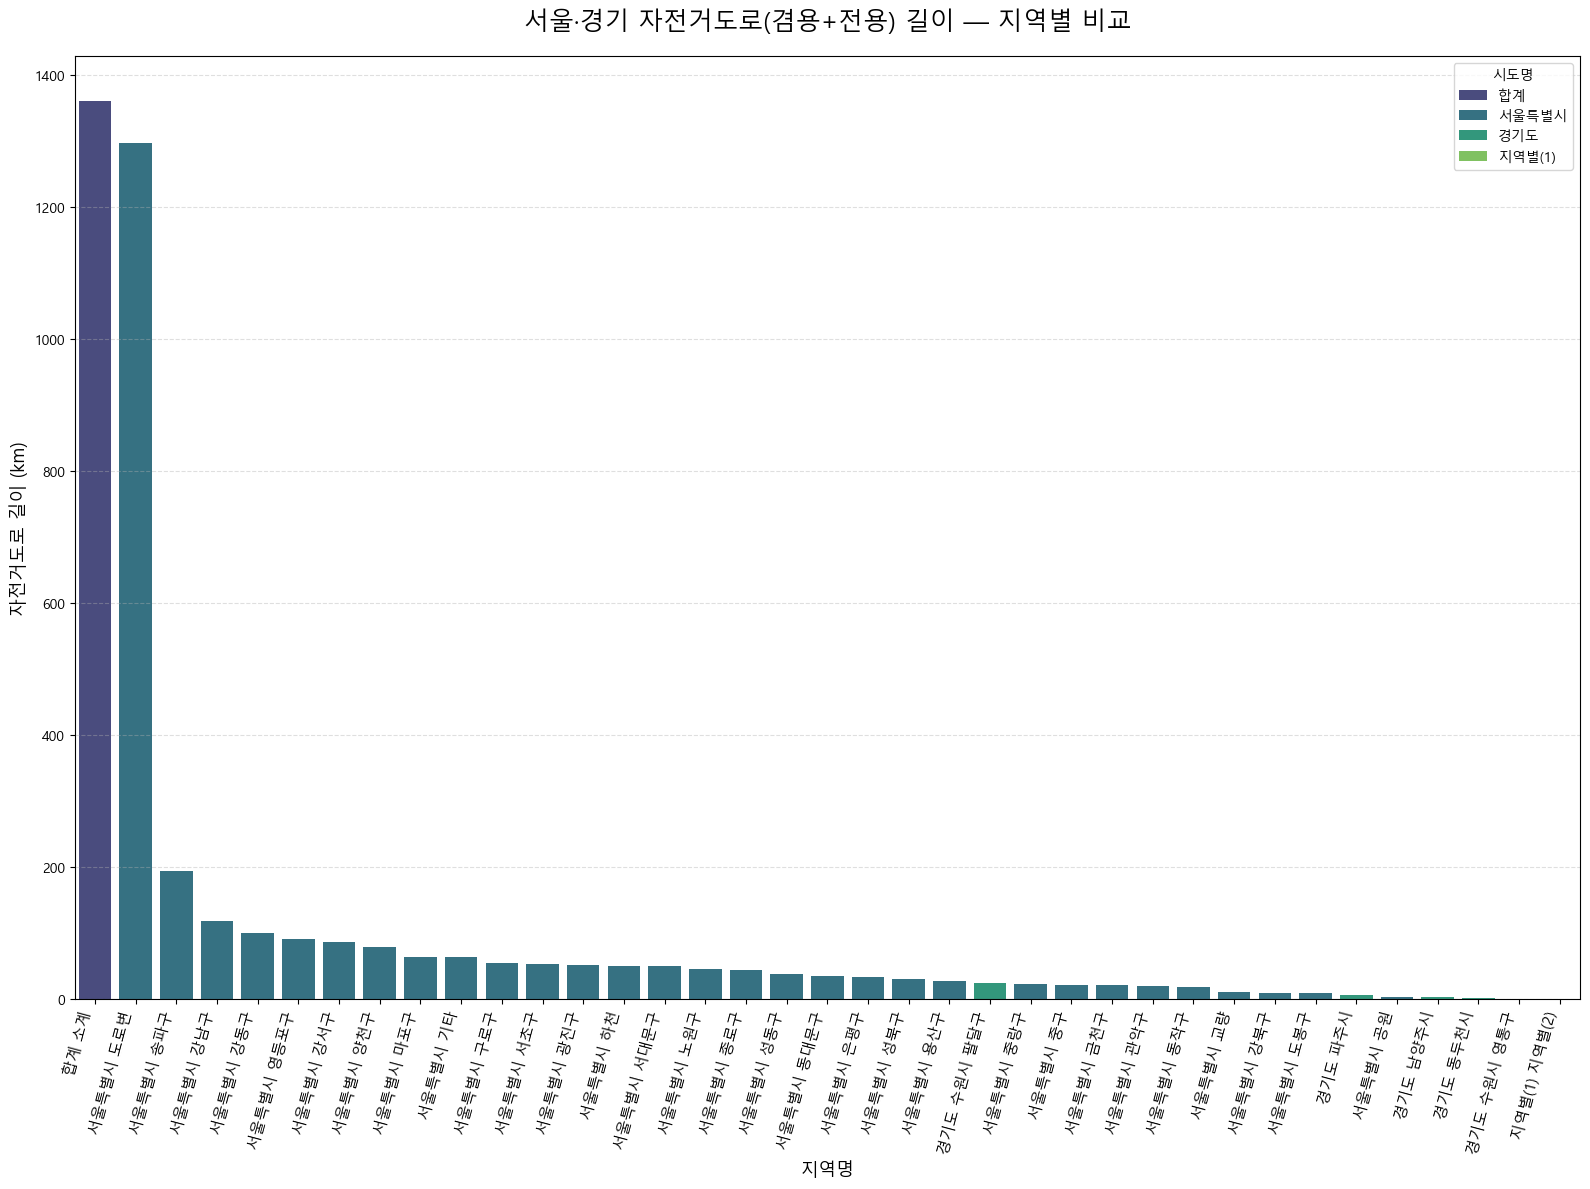

In [11]:
# ==============================================
# ✅ 시각화 — 서울·경기 전체 비교
plt.figure(figsize=(16, 12))
sns.barplot(data=region_all.sort_values('길이_km', ascending=False),
            x='지역명', y='길이_km', hue='시도명', dodge=False, palette='viridis')
plt.title('서울·경기 자전거도로(겸용+전용) 길이 — 지역별 비교', fontsize=18, pad=20)
plt.xlabel('지역명', fontsize=13)
plt.ylabel('자전거도로 길이 (km)', fontsize=13)
plt.xticks(rotation=75, ha='right', fontsize=11)
plt.legend(title='시도명')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

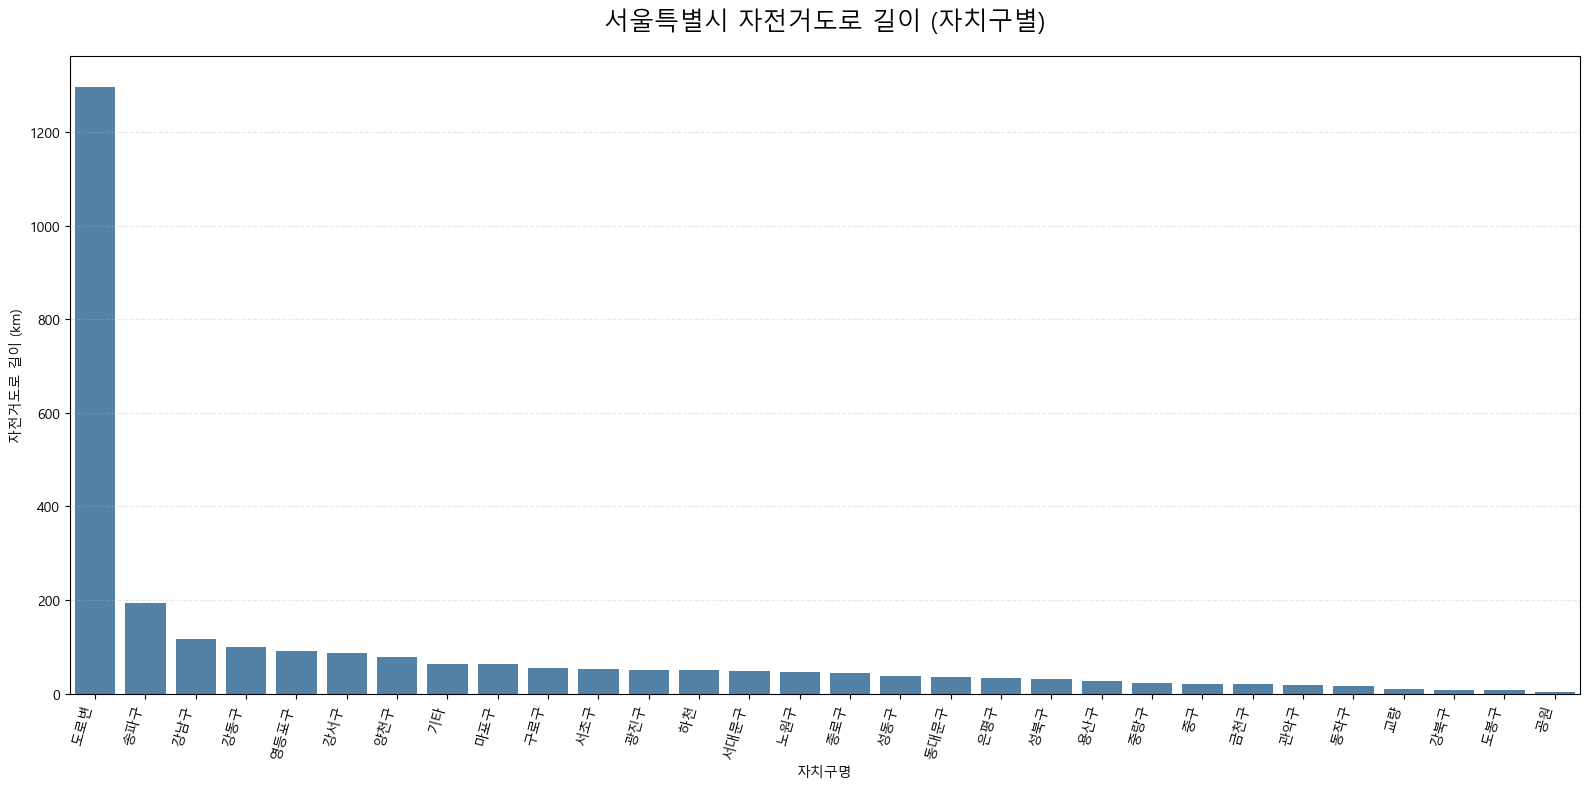

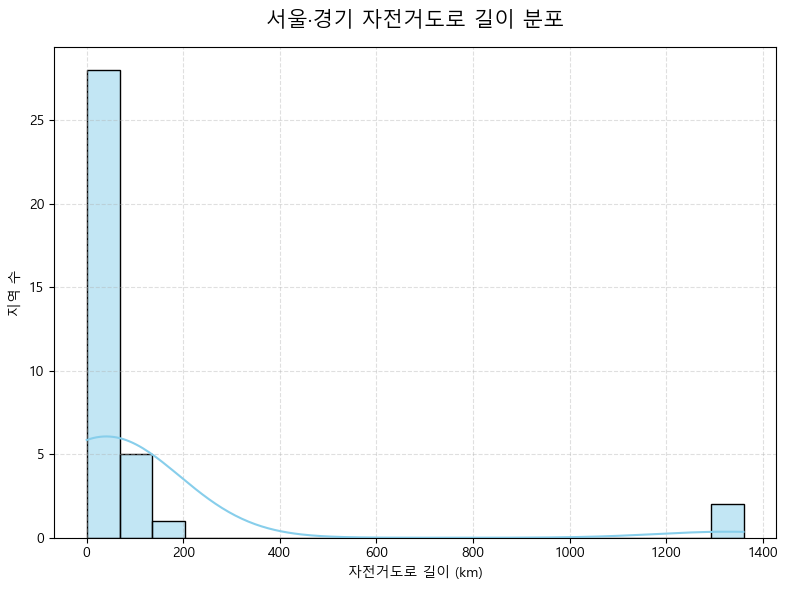

In [12]:
# ✅ 시각화 — 서울 25개 구만 따로
region_seoul_only = region_all[region_all['시도명'] == '서울특별시']
plt.figure(figsize=(16,8))
sns.barplot(data=region_seoul_only.sort_values('길이_km', ascending=False),
            x='시군구명', y='길이_km', color='steelblue')
plt.title('서울특별시 자전거도로 길이 (자치구별)', fontsize=18, pad=20)
plt.xlabel('자치구명')
plt.ylabel('자전거도로 길이 (km)')
plt.xticks(rotation=75, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ✅ 시각화 — 길이 분포
plt.figure(figsize=(8,6))
sns.histplot(region_all['길이_km'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('서울·경기 자전거도로 길이 분포', fontsize=15, pad=15)
plt.xlabel('자전거도로 길이 (km)')
plt.ylabel('지역 수')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
